In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import LogRegAC.logRegAC as logRegAC
import LogRegAC.utilsAC as utilsAC

In [2]:
data = pd.read_csv('data.csv', header=None)
print(data.shape)
data.head()

(200, 3)


,0,1,2
0,6,32,1
1,26,39,1
2,2,38,1
3,25,39,1
4,3,35,1


In [3]:
data = data.sample(frac=1).reset_index(drop=True)
data_x = data.iloc[:, 0:-1]
data_y = data.iloc[:, -1].replace(-1, 0)

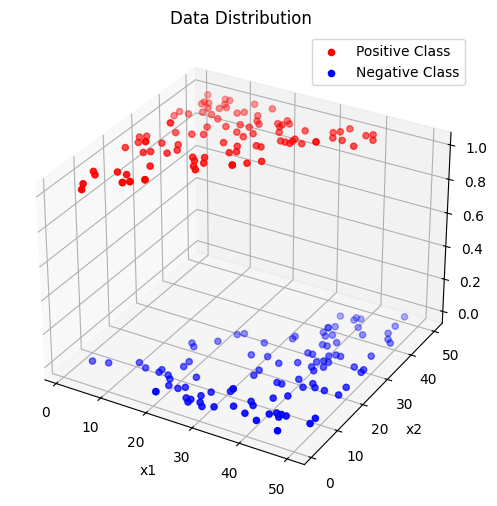

In [4]:
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection='3d')
ax.scatter3D(
    [data_x.iloc[i, 0] for i in range(len(data_x)) if data_y.iloc[i] == 1], 
    [data_x.iloc[i, 1] for i in range(len(data_x)) if data_y.iloc[i] == 1], 
    [i for i in data_y if i == 1], c='red', label='Positive Class')
ax.scatter3D(
    [data_x.iloc[i, 0] for i in range(len(data_x)) if data_y.iloc[i] != 1], 
    [data_x.iloc[i, 1] for i in range(len(data_x)) if data_y.iloc[i] != 1], 
    [i for i in data_y if i != 1], c='blue', label='Negative Class')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y')
plt.legend()
plt.title('Data Distribution')
plt.show()
fig.savefig('plots/data_dist.png')

In [5]:
train_x, train_y, test_x, test_y = utilsAC.splitTrainTest(data_x, data_y, 0.8)
train_x, train_min, train_max = utilsAC.normMinMax(train_x, mode='train')
test_x = utilsAC.normMinMax(test_x, mode='test', train_min=train_min, train_max=train_max)

### Batch Gradient Descent

In [6]:
logReg1 = logRegAC.LogReg(lr=0.01, max_iter=1000)
logReg1.fit(train_x, train_y, iter_step=100)
pred = logReg1.predict(test_x)
print('F1 Score: ', utilsAC.get_performance_measure(test_y, pred)['f1'])

Implementing Batch Gradient Descent.
Iteration     0 | Cost:  110.904
Iteration   100 | Cost:  34.389
Iteration   200 | Cost:  26.728
Iteration   300 | Cost:  23.329
Iteration   400 | Cost:  21.286
Iteration   500 | Cost:  19.875
Iteration   600 | Cost:  18.822
Iteration   700 | Cost:  17.994
Iteration   800 | Cost:  17.320
Iteration   900 | Cost:  16.757
Iteration  1000 | Cost:  16.276
F1 Score:  0.9500000000000001


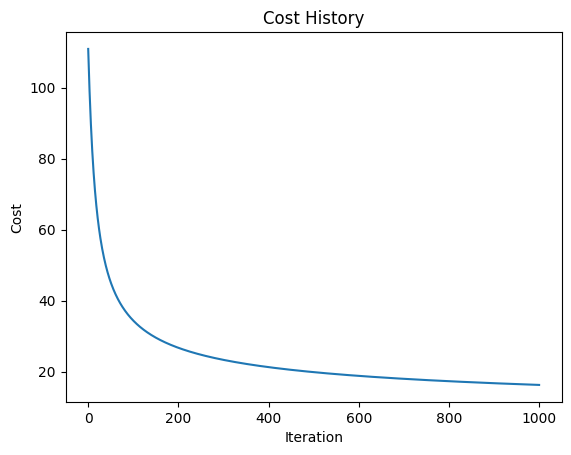

In [7]:
fig = plt.figure()
plt.plot(logReg1.get_cost_hist())
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Cost History')
plt.show()
fig.savefig('plots/gd_cost_hist.png')

In [8]:
gd_trained_weights = logReg1.get_params()
print(f'Trained Weights: {gd_trained_weights}')
gd_cf_info = utilsAC.get_performance_measure(data_y, logReg1.predict(utilsAC.normMinMax(data_x, mode='train')[0]))
gd_cf_matrix = [[gd_cf_info['tn'], gd_cf_info['fn']], [gd_cf_info['fp'], gd_cf_info['tp']]]

Trained Weights: [[  1.21843246]
 [-15.11377487]
 [ 11.59382858]]


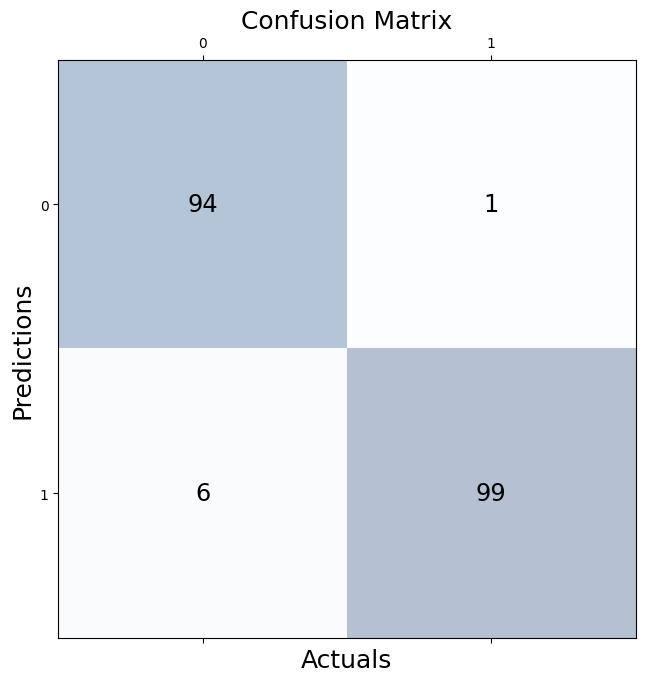

In [9]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(gd_cf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(len(gd_cf_matrix)):
    for j in range(len(gd_cf_matrix[i])):
        ax.text(x=j, y=i,s=gd_cf_matrix[i][j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Actuals', fontsize=18)
plt.ylabel('Predictions', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()
fig.savefig('plots/gd_confusion_matrix.png')

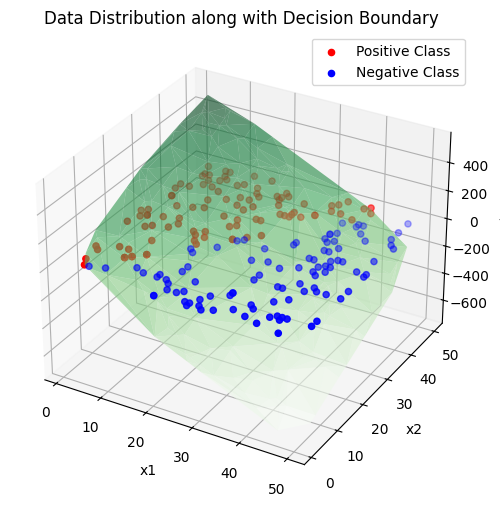

In [10]:
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection='3d')
ax.scatter3D(
    [data_x.iloc[i, 0] for i in range(len(data_x)) if data_y.iloc[i] == 1], 
    [data_x.iloc[i, 1] for i in range(len(data_x)) if data_y.iloc[i] == 1], 
    [i for i in data_y if i == 1], marker='o', c='red', label='Positive Class')
ax.scatter3D(
    [data_x.iloc[i, 0] for i in range(len(data_x)) if data_y.iloc[i] != 1], 
    [data_x.iloc[i, 1] for i in range(len(data_x)) if data_y.iloc[i] != 1], 
    [i for i in data_y if i != 1], marker='o', c='blue', label='Negative Class')

plot_x = np.c_[np.ones((data_x.shape[0], 1)), data_x]
plot_pred = np.dot(plot_x, gd_trained_weights).flatten()
ax.plot_trisurf(data_x[0], data_x[1], plot_pred,
                alpha=0.6,
                cmap='Greens')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y')
plt.legend()
plt.title('Data Distribution along with Decision Boundary')
plt.show()
fig.savefig('plots/gd_data_dist_db.png')

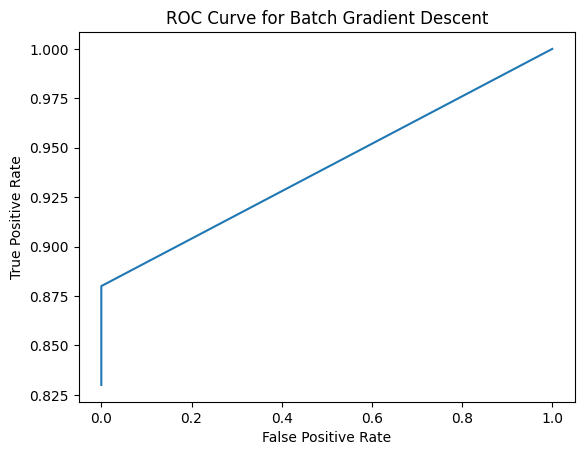

In [11]:
gd_pred_prob = logReg1.predict(data_x, prob=True)
thresh = np.arange(0, 1, 0.001)
gd_tpr = []
gd_fpr = []
for t in thresh:
    gd_pred = [1 if i >= t else 0 for i in gd_pred_prob]
    gd_cf_info = utilsAC.get_performance_measure(data_y, gd_pred)
    tp = gd_cf_info['tp']
    fp = gd_cf_info['fp']
    tn = gd_cf_info['tn']
    fn = gd_cf_info['fn']
    gd_tpr.append(tp/(tp+fn))
    gd_fpr.append(fp/(fp+tn))
fig = plt.figure()
plt.plot(gd_fpr, gd_tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Batch Gradient Descent')
plt.show()
fig.savefig('plots/gd_roc.png')

### Stochastic Gradient Descent

In [12]:
logReg2 = logRegAC.LogReg(lr=0.01, max_iter=1000, stochGd=True)
logReg2.fit(train_x, train_y, iter_step=100)
pred2 = logReg2.predict(test_x)
print('F1 Score: ', utilsAC.get_performance_measure(test_y, pred2)['f1'])

Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  110.904
Iteration   100 | Cost:  34.492
Iteration   200 | Cost:  26.774
Iteration   300 | Cost:  23.358
Iteration   400 | Cost:  21.306
Iteration   500 | Cost:  19.890
Iteration   600 | Cost:  18.834
Iteration   700 | Cost:  18.004
Iteration   800 | Cost:  17.329
Iteration   900 | Cost:  16.764
Iteration  1000 | Cost:  16.282
F1 Score:  0.9500000000000001


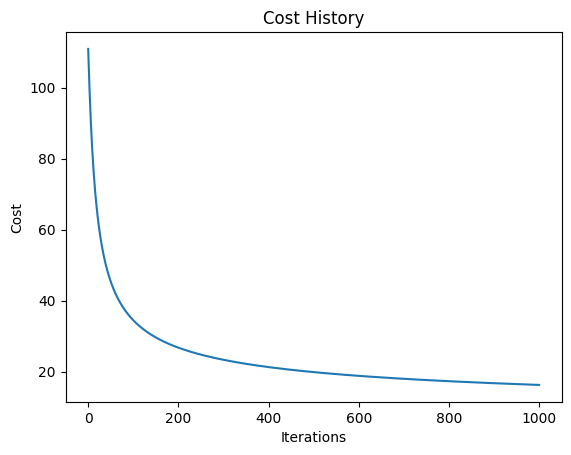

In [13]:
fig = plt.figure()
plt.plot(logReg2.get_cost_hist())
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost History')
plt.show()
fig.savefig('plots/sgd_cost_hist.png')

In [14]:
sgd_trained_weights = logReg2.get_params()
print(f'Trained Weights: {sgd_trained_weights}')
sgd_cf_info = utilsAC.get_performance_measure(data_y, logReg2.predict(utilsAC.normMinMax(data_x, mode='train')[0]))
sgd_cf_matrix = [[sgd_cf_info['tn'], sgd_cf_info['fn']], [sgd_cf_info['fp'], sgd_cf_info['tp']]]

Trained Weights: [[  1.21029355]
 [-15.10286074]
 [ 11.59200344]]


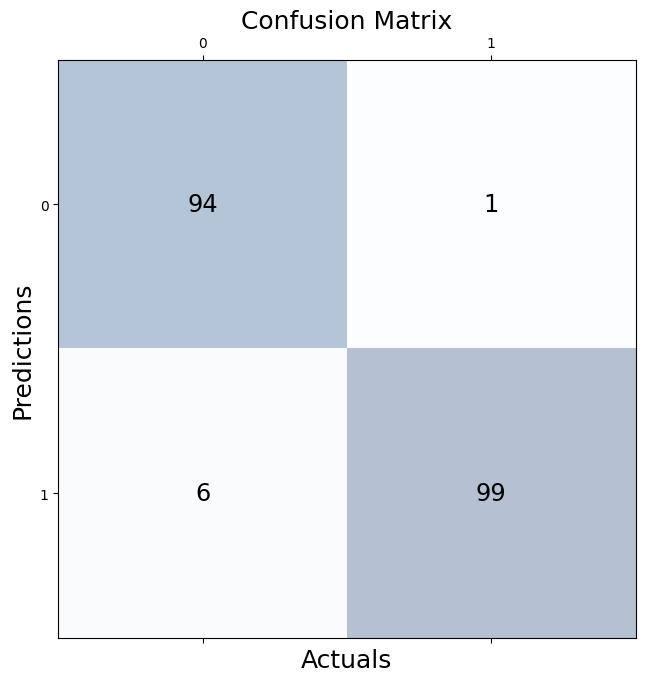

In [15]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(sgd_cf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(len(sgd_cf_matrix)):
    for j in range(len(sgd_cf_matrix[i])):
        ax.text(x=j, y=i,s=sgd_cf_matrix[i][j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Actuals', fontsize=18)
plt.ylabel('Predictions', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()
fig.savefig('plots/sgd_confusion_matrix.png')

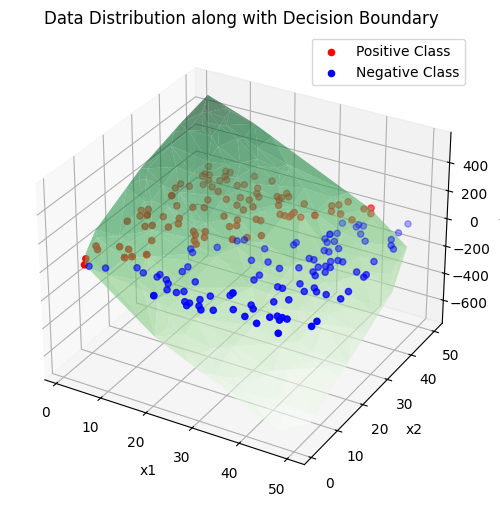

In [16]:
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection='3d')
ax.scatter3D(
    [data_x.iloc[i, 0] for i in range(len(data_x)) if data_y.iloc[i] == 1], 
    [data_x.iloc[i, 1] for i in range(len(data_x)) if data_y.iloc[i] == 1], 
    [i for i in data_y if i == 1], marker='o', c='red', label='Positive Class')
ax.scatter3D(
    [data_x.iloc[i, 0] for i in range(len(data_x)) if data_y.iloc[i] != 1], 
    [data_x.iloc[i, 1] for i in range(len(data_x)) if data_y.iloc[i] != 1], 
    [i for i in data_y if i != 1], marker='o', c='blue', label='Negative Class')

plot_x = np.c_[np.ones((data_x.shape[0], 1)), data_x]
plot_pred = np.dot(plot_x, sgd_trained_weights).flatten()
ax.plot_trisurf(data_x[0], data_x[1], plot_pred,
                alpha=0.6,
                cmap='Greens')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y')
plt.legend()
plt.title('Data Distribution along with Decision Boundary')
plt.show()
fig.savefig('plots/sgd_data_dist_db.png')

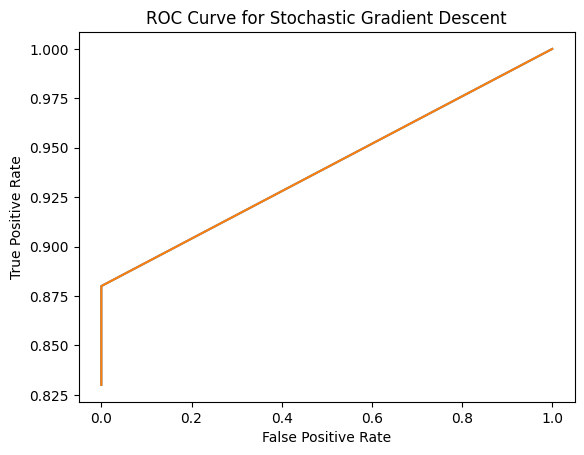

In [17]:
sgd_pred_prob = logReg2.predict(data_x, prob=True)
sgd_tpr = []
sgd_fpr = []
for t in thresh:
    sgd_pred = [1 if i >= t else 0 for i in sgd_pred_prob]
    sgd_cf_info = utilsAC.get_performance_measure(data_y, sgd_pred)
    tp = sgd_cf_info['tp']
    fp = sgd_cf_info['fp']
    tn = sgd_cf_info['tn']
    fn = sgd_cf_info['fn']
    sgd_tpr.append(tp/(tp+fn))
    sgd_fpr.append(fp/(fp+tn))
fig = plt.figure()
plt.plot(sgd_fpr, sgd_tpr)
plt.plot(gd_fpr, gd_tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Stochastic Gradient Descent')
plt.show()
fig.savefig('plots/sgd_roc.png')